In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


import util_copy
import statistics

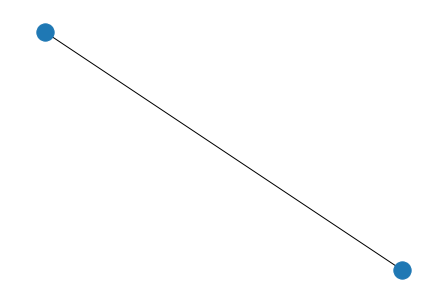

In [2]:
g = nx.Graph()
g.add_edge(0, 1)
nx.draw(g)
plt.show()

In [3]:
def Ising_PBC_dual(g,h):
  E = Z^Z
  B1 = X^I
  B2 = I^X


  H=(h*B1) + \
    (h*B2) + \
    (g*E) 
  return H

In [4]:
g=1
h=1
edge_list=[[0,1]]

In [5]:
def ansatz_ising(num_qubits,measure_list,depth):
  theta = ParameterVector("t",depth*(len(measure_list)+num_qubits))
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,num_qubits))
  circuit.h(qr[i] for i in range (0,num_qubits))
  for _ in range (0,depth): 
    for edge in measure_list:
      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.rz(theta[index],qr[edge[0]])
      circuit.cx(qr[edge[1]],qr[edge[0]])
      index+=1
    circuit.barrier()
    for i in range (0,num_qubits):
      circuit.rx(theta[index], qr[i])
      index+=1
  
    
  return circuit

In [6]:
ansatz=ansatz_ising(2,edge_list,1)
ansatz.draw()

┌───┐┌───┐┌───┐┌──────────┐┌───┐ ░ ┌──────────┐
q0_0: ┤ X ├┤ H ├┤ X ├┤ Rz(t[0]) ├┤ X ├─░─┤ Rx(t[1]) ├
      ├───┤├───┤└─┬─┘└──────────┘└─┬─┘ ░ ├──────────┤
q0_1: ┤ X ├┤ H ├──■────────────────■───░─┤ Rx(t[2]) ├
      └───┘└───┘                       ░ └──────────┘

In [7]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Ising_PBC_dual(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy_ising= np.round(exact_result.eigenvalues[0], 4)

[-2.23606798 -1.          1.          2.23606798]


In [8]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP,NFT

spsa = SPSA(maxiter=5,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=0,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=30, disp=True, rhobeg=1.0, tol=1e-7, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)
nft=NFT(maxiter=50, maxfev=1024, disp=True, reset_interval=100, options=None)

In [9]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,time,callback=None,meas_fitt=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        self._time=time
        self._meas_fitters=meas_fitt
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            if self._meas_fitters is None or (time()-self._time)>180:
                energy_mean,energy_error,meas_fit=util_copy.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti)
                self._meas_fitters=meas_fit
                self._time=time()
                print(meas_fit)
            else:
                print('nocalib')
                energy_mean,energy_error=util_copy.estimator_meas(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=self._meas_fitters)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [10]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback

        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

[[array([[1., 0.],
       [0., 1.]]), array([[1.00000000e+00, 2.77555756e-17],
       [5.55111512e-17, 1.00000000e+00]]), array([0.5, 0.5]), [-0.0, -0.0], array([[1.00000000e+00, 2.77555756e-17],
       [5.55111512e-17, 1.00000000e+00]])], [array([[1., 0.],
       [0., 1.]]), array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]]), array([0.5, 0.5]), [-0.0, 4.440892098500625e-16], array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]])], [array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[ 1.00000000e+00,  9.25185854e-18,  2.89301280e-17,
         9.71445147e-17],
       [-3.70074342e-17,  1.00000000e+00,  2.65990933e-17,
        -1.11022302e-16],
       [-3.70074342e-17,  5.78241159e-17,  1.00000000e+00,
        -2.77555756e-17],
       [ 1.15648232e-16, -7.40148683e-17, -7.40148683e-17,
         1.00000000e+00]]), array([0.25, 0.25, 0.25, 0.25]), [1.4802973661668753e-16, 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


miti_sampler
-2.22944 0.035631080218694204
ideal_energy
-2.2355206431694037
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -2.25276,
    'optimal_circuit': None,
    'optimal_parameters': array([0.46997413, 0.87983648, 0.73929455]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 15.91


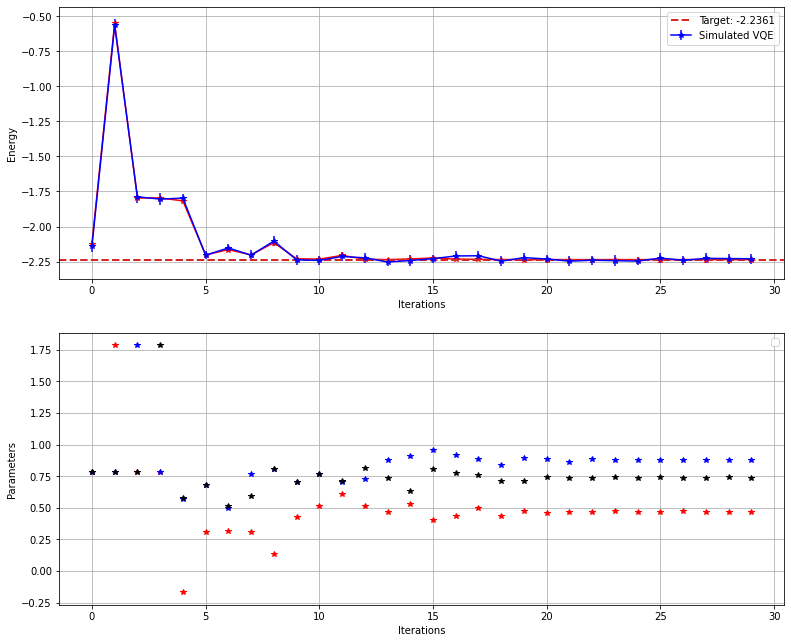

In [11]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=4,time=time(),callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [13]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_belem'
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[1,3]
options.shots=20000

In [13]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')

miti_sampler
-1.72452 0.04430699949310079
ideal_energy
-2.121320343559641
nocalib
miti_sampler
-0.31403999999999993 0.048271155877976646
ideal_energy
-0.5511444335808832
nocalib
miti_sampler
-1.4306 0.045444040492968164
ideal_energy
-1.7962649867431837
nocalib
miti_sampler
-1.4464000000000001 0.051157667448540986
ideal_energy
-1.7962649867431832
nocalib
miti_sampler
-1.48876 0.0412422806630006
ideal_energy
-1.8073655965631858
nocalib
miti_sampler
-1.8002 0.04348479443367273
ideal_energy
-2.2022284962288725
nocalib
miti_sampler
-1.78384 0.04030621565476175
ideal_energy
-2.092394688820683
nocalib
miti_sampler
-1.83784 0.04494604475118482
ideal_energy
-2.201647103135879
nocalib
miti_sampler
-1.5858799999999997 0.03765477989551381
ideal_energy
-1.93372693892331
nocalib
miti_sampler
-1.80744 0.03997023382264275
ideal_energy
-2.171084627850739
nocalib
miti_sampler
-1.808 0.04564634236637775
ideal_energy
-2.2276521268829397
nocalib
miti_sampler
-1.7799599999999998 0.03749139765278407
ideal_en

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


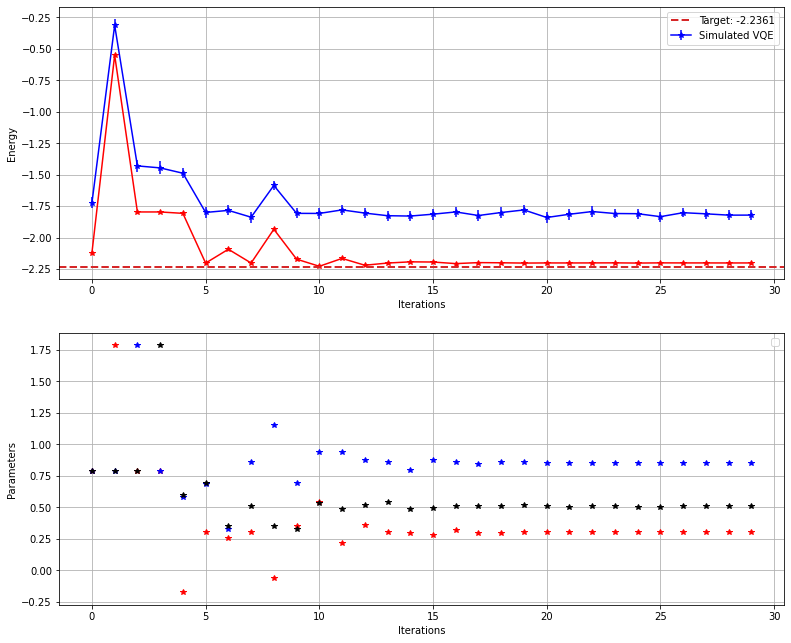

In [14]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_0:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [15]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.8126950000000002
0.012642168665677168


In [16]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


AttributeError: 'NoneType' object has no attribute 'append'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


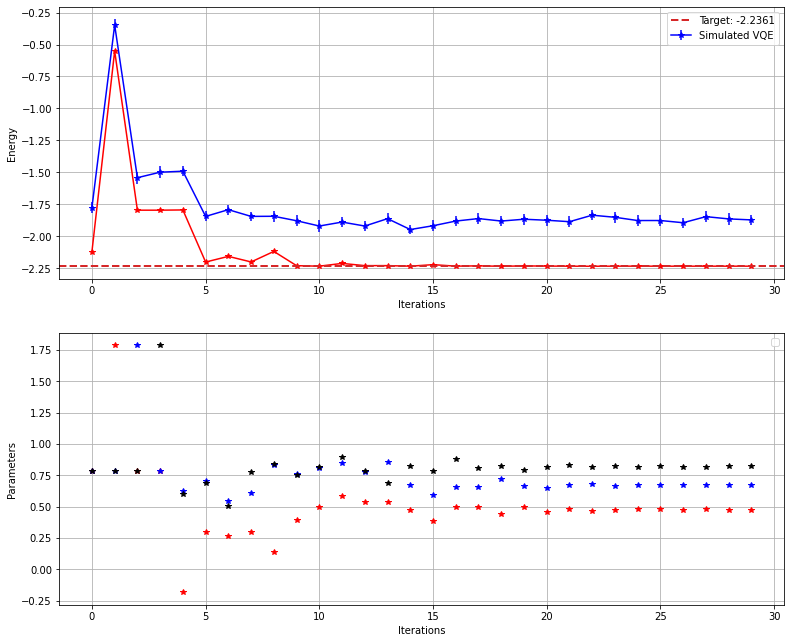

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()



In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.864935
0.019277746608089674


In [15]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


[[array([[0.9893, 0.0354],
       [0.0107, 0.9646]]), array([[ 1.00000000e+00,  1.04074944e-05],
       [-9.95279748e-06,  1.00000000e+00]]), array([0.50023587, 0.49976413]), [0.020661791801769858, 0.021585357403901217], array([[ 1.00000000e+00,  1.04074944e-05],
       [-9.95279748e-06,  1.00000000e+00]])], [array([[0.9925, 0.0375],
       [0.0075, 0.9625]]), array([[ 1.00000000e+00,  1.34546238e-04],
       [-6.08660824e-05,  1.00000000e+00]]), array([0.50301047, 0.49698953]), [0.010007885577701688, 0.02185791588410245], array([[ 1.00000000e+00,  1.34546238e-04],
       [-6.08660824e-05,  1.00000000e+00]])], [array([[9.797e-01, 3.660e-02, 4.020e-02, 1.300e-03],
       [9.900e-03, 9.545e-01, 1.900e-03, 3.850e-02],
       [1.030e-02, 1.100e-03, 9.523e-01, 3.490e-02],
       [1.000e-04, 7.800e-03, 5.600e-03, 9.253e-01]]), array([[ 1.00000000e+00,  2.41878725e-03, -2.39051285e-03,
        -1.25986876e-02],
       [ 3.20242474e-03,  1.00000000e+00, -4.74540821e-03,
         2.30382823e-02

: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


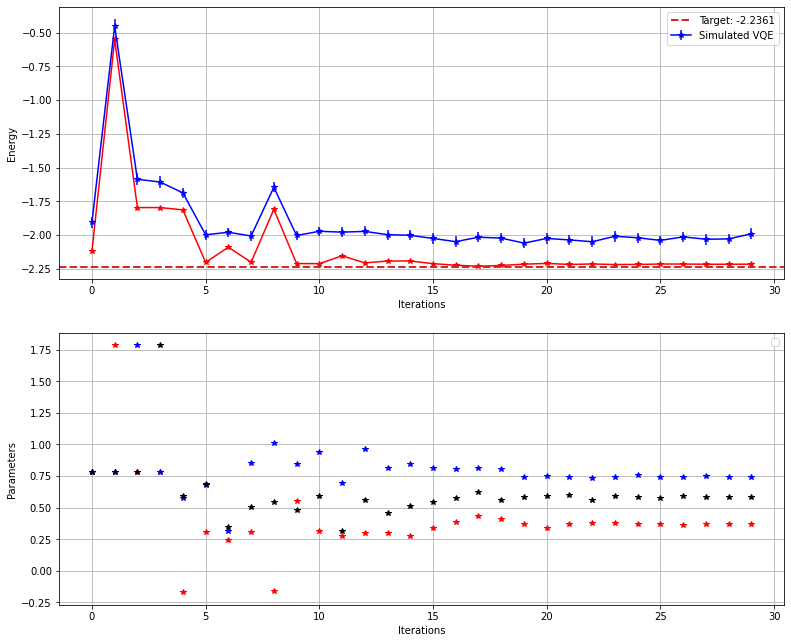

In [15]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [16]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.022535
0.01857072273383952


In [18]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


AttributeError: 'NoneType' object has no attribute 'quasi_dists'

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_3:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

NameError: name 'intermediate_info_real_backend_3' is not defined

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.8589845127422295
0.023350428837356465


In [14]:
# Define a simple callback function
intermediate_info_real_backend_4= []
def callback(value):
        intermediate_info_real_backend_4.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=4,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


[[array([[0.9895, 0.0516],
       [0.0105, 0.9484]]), array([[ 1.00000000e+00,  2.65360935e-05],
       [-2.42083562e-05,  1.00000000e+00]]), array([0.50053311, 0.49946689]), [0.022200859615726088, 0.024283728837624464], array([[ 1.00000000e+00,  2.65360935e-05],
       [-2.42083562e-05,  1.00000000e+00]])], [array([[0.9901, 0.0519],
       [0.0099, 0.9481]]), array([[ 1.00000000e+00,  2.77952986e-05],
       [-2.11400828e-05,  1.00000000e+00]]), array([0.50090599, 0.49909401]), [0.01153229330546155, 0.015107982405886252], array([[ 1.00000000e+00,  2.77952986e-05],
       [-2.11400828e-05,  1.00000000e+00]])], [array([[9.843e-01, 4.070e-02, 3.810e-02, 3.500e-03],
       [9.900e-03, 9.515e-01, 1.700e-03, 3.370e-02],
       [5.700e-03, 1.600e-03, 9.539e-01, 4.930e-02],
       [1.000e-04, 6.200e-03, 6.300e-03, 9.135e-01]]), array([[ 1.        ,  0.0107667 ,  0.00814779, -0.01050289],
       [ 0.00224084,  1.        , -0.00893459,  0.01687222],
       [-0.0011744 , -0.00676314,  1.        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


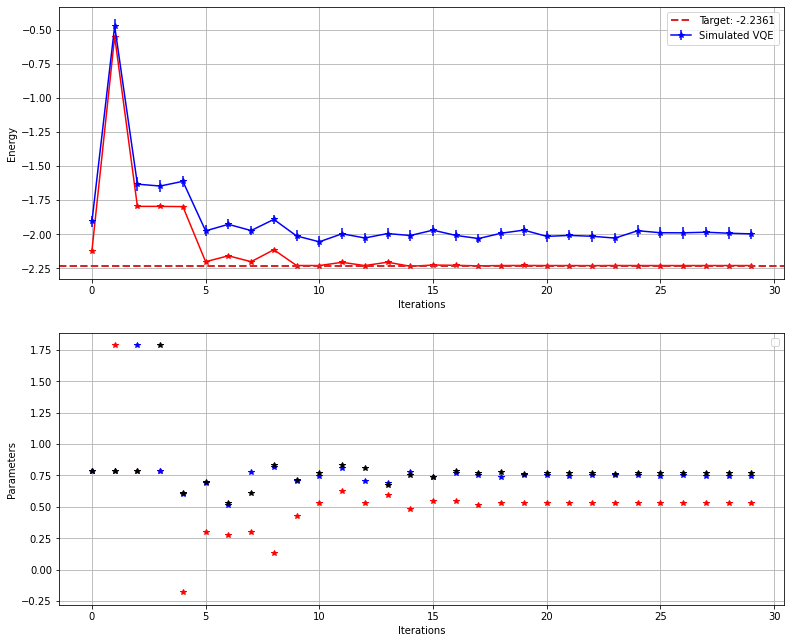

In [16]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_4:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [17]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.996955
0.017269274945487908


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)


options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[1,2]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,time=time(),callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

KeyboardInterrupt: 

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.8636875
0.02306038269413582


ideal_energy
-2.1822947994675164
miti_energy
-2.1411432281663685
ideal_energy
-0.9239557652417313
miti_energy
-0.9127415361544313
ideal_energy
-2.1262176296366744
miti_energy
-2.0582814367869093
ideal_energy
-2.126217629636674
miti_energy
-2.0198838752880706
ideal_energy
-1.4768458008946947
miti_energy
-1.4069833311747901
ideal_energy
-2.0606814105242774
miti_energy
-1.8987037626567198
ideal_energy
-2.017696408094128
miti_energy
-2.004195250047544
ideal_energy
-2.1752885631569208
miti_energy
-2.083836532136592
ideal_energy
-2.218372014621492
miti_energy
-2.1958999747616654
ideal_energy
-2.2346490589027743
miti_energy
-2.1756424900228057
ideal_energy
-2.205946231991924
miti_energy
-2.1417068349163606
ideal_energy
-2.2289489954193815
miti_energy
-2.189834968246185
ideal_energy
-2.2217002334208633
miti_energy
-2.1577765359776584
ideal_energy
-2.219713243473992
miti_energy
-2.1464773708831943
ideal_energy
-2.2150943362113997
miti_energy
-2.130308352002524
ideal_energy
-2.225105157292375
mi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ideal_energy
-2.217019639760611
miti_energy
-2.144530094988043
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -2.2206906784873826,
    'optimal_circuit': None,
    'optimal_parameters': array([0.59346504, 0.60505884, 0.94128578]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 2317.33
[[0.5709730165518592, 0.4160957750534391, 0.7631256644298493], [1.5709730165518592, 0.4160957750534391, 0.7631256644298493], [0.5709730165518592, 1.416095775053439, 0.7631256644298493], [0.5709730165518592, 0.4160957750534391, 1.7631256644298494], [-0.4219554809900783, 0.34911781942779646, 0.6651106031927096], [0.07450876778089044, 0.38260679724061775, 0.7141181338112795], [0.8110601774593553, 0.3767710340199275, 0.7055781196514204], [0.5709730165518592, 0.31289068393928815, 0.8336501932699614], [0.588038187586414, 0.5906367829143

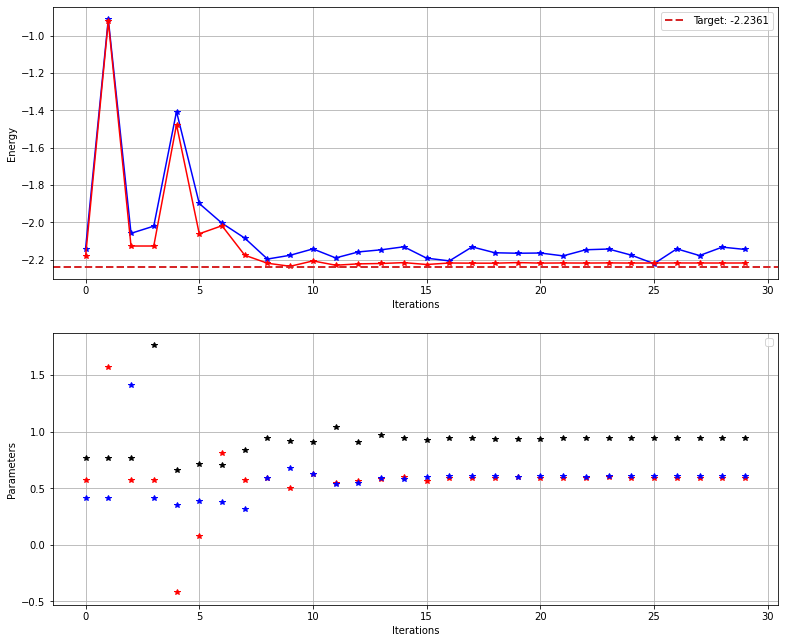

In [16]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=[3,5]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [21]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.1074698468487325
0.03620984465181403


ideal_energy
-2.0283724057704653
miti_energy
-1.7809583333333343
ideal_energy
-1.4488908037398294
miti_energy
-1.2540000000000007
ideal_energy
-2.055665042288509
miti_energy
-1.8012916666666665
ideal_energy
-2.0285578744165575
miti_energy
-1.7675000000000007
ideal_energy
-0.37671184145210135
miti_energy
-0.25849999999999995
ideal_energy
-2.2258912716705126
miti_energy
-1.9265416666666675
ideal_energy
-1.8584834366770777
miti_energy
-1.6794166666666677
ideal_energy
-2.209876088074921
miti_energy
-1.8710416666666676
ideal_energy
-1.939479022149048
miti_energy
-1.6761666666666668
ideal_energy
-2.213501953710506
miti_energy
-1.9936250000000018
ideal_energy
-2.1852185015973307
miti_energy
-1.8738750000000008
ideal_energy
-2.195227187021763
miti_energy
-1.8785833333333342
ideal_energy
-2.079538895154976
miti_energy
-1.8763333333333339
ideal_energy
-2.2171680316960476
miti_energy
-1.8944166666666677
ideal_energy
-2.194598750978317
miti_energy
-1.9404166666666673
ideal_energy
-2.21347801897926

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ideal_energy
-2.213376926756755
miti_energy
-1.9337500000000005
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -1.995875000000001,
    'optimal_circuit': None,
    'optimal_parameters': array([0.55562631, 1.37751386, 0.41675256]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 1155.79
[[0.05920378963728966, 0.12062008625674495, 0.44831369953969713], [1.0592037896372897, 0.12062008625674495, 0.44831369953969713], [0.05920378963728966, 1.120620086256745, 0.44831369953969713], [0.05920378963728966, 1.120620086256745, 1.448313699539697], [-0.9380074073883151, 1.1590987028573987, 0.3843666543283629], [0.5590420361871787, 1.127176859830061, 0.4374170942774852], [1.0529141991563242, 1.1674131011221625, 0.3705490785236018], [0.5535932650366406, 1.127176859830061, 0.187476479544807], [0.9395203175516751, 1.1575116134771

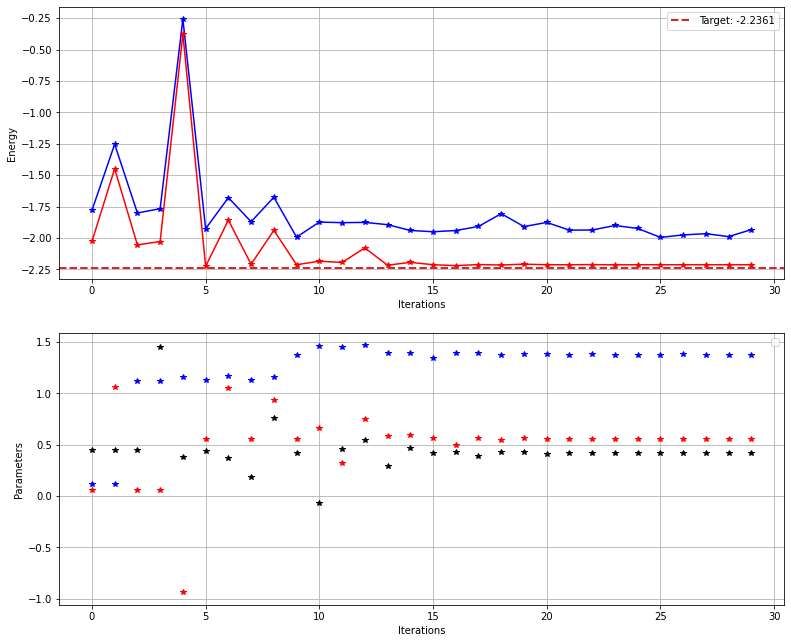

In [23]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=[3,5]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [24]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.9530104166666673
0.03386306568020554


In [15]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=[1,2]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

ideal_energy
-2.0744645228196776
miti_energy
-2.153311739448268
ideal_energy
-0.7617861014997125
miti_energy
-0.7993497387515204


KeyboardInterrupt: 

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)